In [1]:
import os
import pickle
import pprint
from pathlib import Path
from collections import OrderedDict, defaultdict
from easydict import EasyDict

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from tqdm import tqdm

from batch_engine import valid_trainer, batch_trainer
from config import argument_parser
from dataset.AttrDataset import AttrDataset, get_transform
from loss.CE_loss import CEL_Sigmoid
from models.base_block import FeatClassifier, BaseClassifier
from models.resnet import resnet50, resnet101

from tools.function import get_model_log_path, get_pedestrian_metrics
from tools.utils import time_str, save_ckpt, ReDirectSTD, set_seed, AverageMeter
from tools.attributes_dict import attr_list

In [2]:
args = EasyDict()
args.dataset = "test"
args.redirector = True
# args.device
args.valid_split = "test"
args.test_batchsize = 1
args.attr_num = 48
args.height = 256
args.width = 192
args.threshold = 0.5
# args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PETA/2020-12-10_16:17:39_ep_30_bs_64/img_model/ckpt_max.pth' 
# args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PA100k/2020-12-10_20:28:54_ep_30_bs_64/img_model/ckpt_max.pth' 
args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/combined/2020-12-12_11:42:11_ep_30_bs_64/img_model/ckpt_max.pth'

In [3]:
def get_reload_weight(model_path, model):
    # 加载到cpu
    model_dict = torch.load(model_path) #, map_location=lambda storage, loc: storage
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in model_dict["state_dicts"].items():
        name = k[7:]  # 去掉 `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    return model

_, valid_tsfm = get_transform(args)

valid_set = AttrDataset(args=args, split=args.valid_split, transform=valid_tsfm)

valid_loader = DataLoader(
    dataset=valid_set,
    batch_size=args.test_batchsize,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

print(f'{args.valid_split} set: {len(valid_loader.dataset)}, '
      f'attr_num : {args.attr_num}')

backbone = resnet50()
classifier = BaseClassifier(nattr=args.attr_num)
model = FeatClassifier(backbone, classifier).cuda()
# if torch.cuda.is_available():
#     model = torch.nn.DataParallel(model).cuda()

print("reloading pretrained models")

model_path = args.pretrained_model
model = get_reload_weight(model_path, model)

valid_iter = iter(valid_loader)
input_data,_,_ = next(valid_iter)
input_data = input_data.cuda()

# export
torch.onnx.export(model,                     # model being run
                  input_data,                # model input (or a tuple for multiple inputs)
                  "par.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  verbose=True,
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

test set: 140, attr_num : 48
reloading pretrained models
graph(%input : Float(1:147456, 3:49152, 256:192, 192:1),
      %backbone.conv1.weight : Float(64:147, 3:49, 7:7, 7:1),
      %backbone.bn1.weight : Float(64:1),
      %backbone.bn1.bias : Float(64:1),
      %backbone.bn1.running_mean : Float(64:1),
      %backbone.bn1.running_var : Float(64:1),
      %backbone.layer1.0.conv1.weight : Float(64:64, 64:1, 1:1, 1:1),
      %backbone.layer1.0.bn1.weight : Float(64:1),
      %backbone.layer1.0.bn1.bias : Float(64:1),
      %backbone.layer1.0.bn1.running_mean : Float(64:1),
      %backbone.layer1.0.bn1.running_var : Float(64:1),
      %backbone.layer1.0.conv2.weight : Float(64:576, 64:9, 3:3, 3:1),
      %backbone.layer1.0.bn2.weight : Float(64:1),
      %backbone.layer1.0.bn2.bias : Float(64:1),
      %backbone.layer1.0.bn2.running_mean : Float(64:1),
      %backbone.layer1.0.bn2.running_var : Float(64:1),
      %backbone.layer1.0.conv3.weight : Float(256:64, 64:1, 1:1, 1:1),
      %ba

In [4]:
model.eval()
valid_logits = model(input_data)
valid_probs = torch.sigmoid(valid_logits)
import onnxruntime as ort
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_session = ort.InferenceSession('par.onnx')

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(input_data)}

ort_outs = ort_session.run(None, ort_inputs)

print(ort_outs[0], valid_logits)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(valid_logits), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

[[-6.149455  -6.6986303  4.061226  -3.5802479 -4.3290606  5.2551546
  -4.2256846 -5.899272  -5.972822  -4.8952837 -4.6752396 -2.7022552
   6.400148  -6.3657656 -3.6024969 -6.190031  -5.73082    4.318412
  -4.907749  -6.218342  -3.2780914 -5.025901  -4.858263   0.6802373
  -5.337975  -5.705943  -0.9061099 -5.3126197 -2.8510435 -3.223333
  -5.0304117 -2.177093  -4.981524   6.6908884 -4.003     -4.6632586
  -5.2366695 -3.415151  -6.0848155 -5.1463366 -3.8363411  2.7905157
  -5.3105416 -5.7150683 -5.0601497 -5.3095026 -2.507124  -2.5963867]] tensor([[-6.1495, -6.6986,  4.0612, -3.5802, -4.3291,  5.2552, -4.2257, -5.8993,
         -5.9728, -4.8953, -4.6752, -2.7023,  6.4001, -6.3658, -3.6025, -6.1900,
         -5.7308,  4.3184, -4.9077, -6.2183, -3.2781, -5.0259, -4.8583,  0.6802,
         -5.3380, -5.7059, -0.9061, -5.3126, -2.8510, -3.2233, -5.0304, -2.1771,
         -4.9815,  6.6909, -4.0030, -4.6633, -5.2367, -3.4152, -6.0848, -5.1463,
         -3.8363,  2.7905, -5.3105, -5.7151, -5.060

In [18]:
input_data.shape

torch.Size([1, 3, 256, 192])

In [125]:
valid_result = get_pedestrian_metrics(gt_label, preds_probs, threshold=args.threshold)

print(f'Evaluation on test set, \n',
      'ma: {:.4f},  pos_recall: {:.4f} , neg_recall: {:.4f} \n'.format(
          valid_result.ma, np.mean(valid_result.label_pos_recall), np.mean(valid_result.label_neg_recall)),
      'Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}'.format(
          valid_result.instance_acc, valid_result.instance_prec, valid_result.instance_recall,
          valid_result.instance_f1))

In [126]:
args.pretrained_model = '/home/pantengteng/Programs/Strong_Baseline_of_Pedestrian_Attribute_Recognition/exp_result/PA100k/2020-12-10_20:28:54_ep_30_bs_64/img_model/ckpt_max.pth' 
def get_reload_weight(model_path, model):
    # 加载到cpu
    model_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in model_dict["state_dicts"].items():
        name = k[7:]  # 去掉 `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    return model

visenv_name = args.dataset
exp_dir = os.path.join('exp_result', args.dataset)
model_dir, log_dir = get_model_log_path(exp_dir, visenv_name)
stdout_file = os.path.join(log_dir, f'stdout_{time_str()}.txt')

if args.redirector:
    print('redirector stdout')
    ReDirectSTD(stdout_file, 'stdout', False)

pprint.pprint(OrderedDict(args.__dict__))

print('-' * 60)


train_tsfm, valid_tsfm = get_transform(args)

valid_set = AttrDataset(args=args, split=args.valid_split, transform=valid_tsfm)

valid_loader = DataLoader(
    dataset=valid_set,
    batch_size=args.test_batchsize,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

print(f'{args.valid_split} set: {len(valid_loader.dataset)}, '
      f'attr_num : {args.attr_num}')

backbone = resnet50()
classifier = BaseClassifier(nattr=args.attr_num)
model = FeatClassifier(backbone, classifier)
# if torch.cuda.is_available():
#     model = torch.nn.DataParallel(model).cuda()

print("reloading pretrained models")

model_path = args.pretrained_model
model = get_reload_weight(model_path, model)

model.eval()
preds_probs = []
gt_list = []
with torch.no_grad():
    for step, (imgs, gt_label, imgname) in enumerate(tqdm(valid_loader)):
        # imgs = imgs.cuda()
        # gt_label = gt_label.cuda()
        gt_list.append(gt_label.cpu().numpy())
        gt_label[gt_label == -1] = 0
        valid_logits = model(imgs)
        valid_probs = torch.sigmoid(valid_logits)
        preds_probs.append(valid_probs.cpu().numpy())
gt_label = np.concatenate(gt_list, axis=0)
preds_probs = np.concatenate(preds_probs, axis=0)

valid_result0 = get_pedestrian_metrics(gt_label, preds_probs, threshold=args.threshold)

print(f'Evaluation on test set, \n',
      'ma: {:.4f},  pos_recall: {:.4f} , neg_recall: {:.4f} \n'.format(
          valid_result.ma, np.mean(valid_result.label_pos_recall), np.mean(valid_result.label_neg_recall)),
      'Acc: {:.4f}, Prec: {:.4f}, Rec: {:.4f}, F1: {:.4f}'.format(
          valid_result.instance_acc, valid_result.instance_prec, valid_result.instance_recall,
          valid_result.instance_f1))

100%|██████████| 140/140 [00:09<00:00, 14.26it/s]


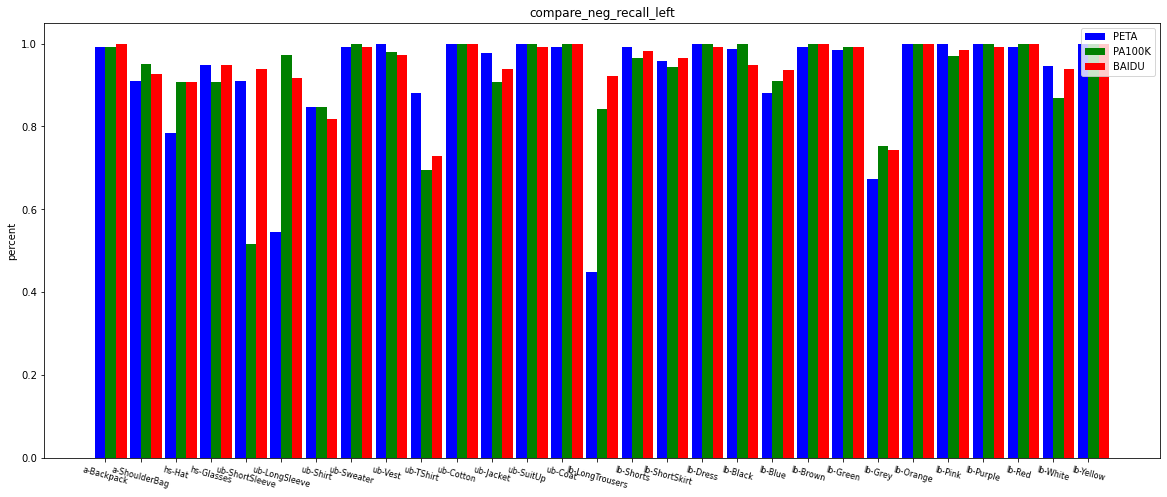

In [138]:
# valid_result = get_pedestrian_metrics(gt_label, preds_probs, threshold=0.3)
# 这两行代码解决 plt 中文显示的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 输入统计数据
#atts = attr_list[0:8] + attr_list[22:33]
atts = attr_list[8:22] + attr_list[33:]

bar_width = 0.3  # 条形宽度
index_PETA = np.arange(len(atts))  # PETA的横坐标
index_PA100K = index_PETA + bar_width  # pa100k的横坐标
index_BAIDU = index_PA100K + bar_width  #BAIDU的横坐标

plt.figure(figsize=(20,8)) 
# 使用两次 bar 函数画出两组条形图
#plt.bar(index_PETA, height=np.concatenate((valid_result.label_prec[0:8],valid_result.label_prec[22:33]), 0), width=bar_width, color='b', label='PETA')
#plt.bar(index_PA100K, height=np.concatenate((valid_result0.label_prec[0:8],valid_result0.label_prec[22:33]), 0), width=bar_width, color='g', label='PA100K')
#plt.bar(index_BAIDU, height=np.concatenate((valid_result1.label_prec[0:8],valid_result1.label_prec[22:33]), 0), width=bar_width, color='r', label='BAIDU')
# plt.bar(index_R, height=valid_result.label_neg_recall, width=bar_width, color='r', label='neg_recall')
plt.bar(index_PETA, height=np.concatenate((valid_result.label_neg_recall[8:22],valid_result.label_neg_recall[33:]), 0), width=bar_width, color='b', label='PETA')
plt.bar(index_PA100K, height=np.concatenate((valid_result0.label_neg_recall[8:22],valid_result0.label_neg_recall[33:]), 0), width=bar_width, color='g', label='PA100K')
plt.bar(index_BAIDU, height=np.concatenate((valid_result1.label_neg_recall[8:22],valid_result1.label_neg_recall[33:]), 0), width=bar_width, color='r', label='BAIDU')

plt.legend()  # 显示图例
plt.xticks(index_PETA + bar_width/2, atts) 
plt.tick_params(axis='x', labelsize=8)
plt.xticks(rotation=-15) 
plt.ylabel('percent')  # 纵坐标轴标题
plt.title('compare_neg_recall_left')  # 图形标题
plt.savefig('./test_baidu_neg_recall_left.jpg')

plt.show()

In [120]:
np.concatenate((valid_result.label_prec[0:8],valid_result.label_prec[22:33]), 0)

array([0.72413793, 0.        , 0.7037037 , 0.06666667, 0.        ,
       0.85      , 0.82352941, 0.34375   , 1.        , 0.57142857,
       0.6       , 0.875     , 0.35714286, 0.        , 0.36363636,
       0.16666667, 0.66666667, 0.64383562, 0.        ])